In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping

- x = dados de uti
- y = sepse/nao sepse
- mask serve para indicar quais posicoes da sequencia sao reais e quais tem zeros adicionados
- mask_bal e um array que informa quais partes da sequencia devem ser ignoradas pelo modelo

In [ ]:
dados = np.load("/content/mimic_X_y_mask_10j_clean_bal.npz")

# Extraindo os arrays
X_bal = dados["X"]
y_bal = dados["y"]
mask_bal = dados["mask"]

print("Dados carregados da versão balanceada")
print(f"Total de amostras: {len(y_bal)}")
print(f"Com Sepse: {np.sum(y_bal == 1)}")
print(f"Sem Sepse: {np.sum(y_bal == 0)}")

Dados carregados da versão balanceada
Total de amostras: 13560
Com Sepse: 6780
Sem Sepse: 6780


- masking ignora os zeros (padding)
- camadas empilhadas com 128 e 64 neuronios
- desativa 50% dos neuronios com dropout pra evitar overfitting
- regulacao l2 para ajudar o modelo a nao memorizar os dados de treino
- camada dense para classificacao binaria com 1 neuronio retornando 0 ou 1
- otimizador adam (ajusta pesos) com taxa de aprendizado de 0.0005 (valor bom para nao deixar o modelo instavel nem aprender muito devagar)
- early stopping para interromper o treinamento se nao melhorar depois de 5 epochs (patience=5)
- 100 epochs
- batch_size = 32 corresponde a 32 amostras por lote

In [ ]:
# Divisão treino + temp (validação+teste)
X_train, X_temp, y_train, y_temp, mask_train, mask_temp = train_test_split(
    X_bal, y_bal, mask_bal, test_size=0.30, random_state=42, stratify=y_bal
)

# Divisão temp => validação e teste (50/50% de 30%)
X_val, X_test, y_val, y_test, mask_val, mask_test = train_test_split(
    X_temp, y_temp, mask_temp, test_size=0.50, random_state=42, stratify=y_temp
)

# Forma da entrada
input_shape = X_train.shape[1:]

# Definição do modelo LSTM
inputs = tf.keras.Input(shape=input_shape)
x = layers.Masking(mask_value=0.0)(inputs)
x = layers.LSTM(128, return_sequences=True)(x)
x = layers.LSTM(64)(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs, outputs)

# Compilar o modelo
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.AUC(name='auc'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Treinamento
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop]
)

Epoch 1/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 17s 31ms/step - accuracy: 0.5618 - auc: 0.5829 - loss: 0.7404 - precision: 0.5588 - recall: 0.5656 - val_accuracy: 0.6190 - val_auc: 0.6590 - val_loss: 0.6989 - val_precision: 0.6414 - val_recall: 0.5398
Epoch 2/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.6114 - auc: 0.6478 - loss: 0.6959 - precision: 0.6105 - recall: 0.6031 - val_accuracy: 0.6332 - val_auc: 0.6810 - val_loss: 0.6731 - val_precision: 0.6367 - val_recall: 0.6205
Epoch 3/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.6223 - auc: 0.6738 - loss: 0.6733 - precision: 0.6179 - recall: 0.6601 - val_accuracy: 0.6323 - val_auc: 0.6844 - val_loss: 0.6637 - val_precision: 0.6155 - val_recall: 0.7050
Epoch 4/100
297/297 ━━━━━━━━━━━━━━━━━━━━ 11s 31ms/step - accuracy: 0.6435 - auc: 0.6879 - loss: 0.6599 - precision: 0.6365 - recall: 0.6729 - val_accuracy: 0.6347 - val_auc: 0.6799 - val_loss: 0.6648 - val_precision: 0.6631 - val_recall: 0.5477
Epoch 5/100
297/297 ━━

- limiar de corte de 0.5, ou seja, se a probabilidade for ≥ 0.5 o modelo classifica como sepse
- auc = mede quao bem o modelo separa as classes (modelo razoavel com 0.71 de auc)
- precision = proporcao de acertos entre os casos classificados como positivos (64% dos alertas de sepse foram corretos)
- acuracia de 65%

64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Acurácia: 0.6519
AUC: 0.7148
Precisão: 0.6398
Revocação: 0.6952
F1-score: 0.6664


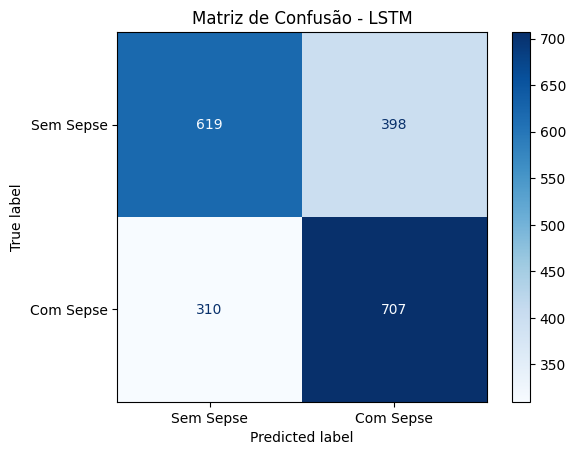

In [ ]:
# Previsão das probabilidades no conjunto de teste
y_pred_prob = model.predict(X_test).flatten()

# Limiar de classificação
limiar = 0.5
y_pred = (y_pred_prob >= limiar).astype(int)

from sklearn.metrics import accuracy_score;
# Cálculo das métricas
print(f"Acurácia: {accuracy_score(y_test, y_pred):.4f}")
print(f"AUC: {roc_auc_score(y_test, y_pred_prob):.4f}")
print(f"Precisão: {precision_score(y_test, y_pred):.4f}")
print(f"Revocação: {recall_score(y_test, y_pred):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred):.4f}")

# Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Sem Sepse", "Com Sepse"])
disp.plot(cmap='Blues')
plt.title("Matriz de Confusão - LSTM")
plt.show()

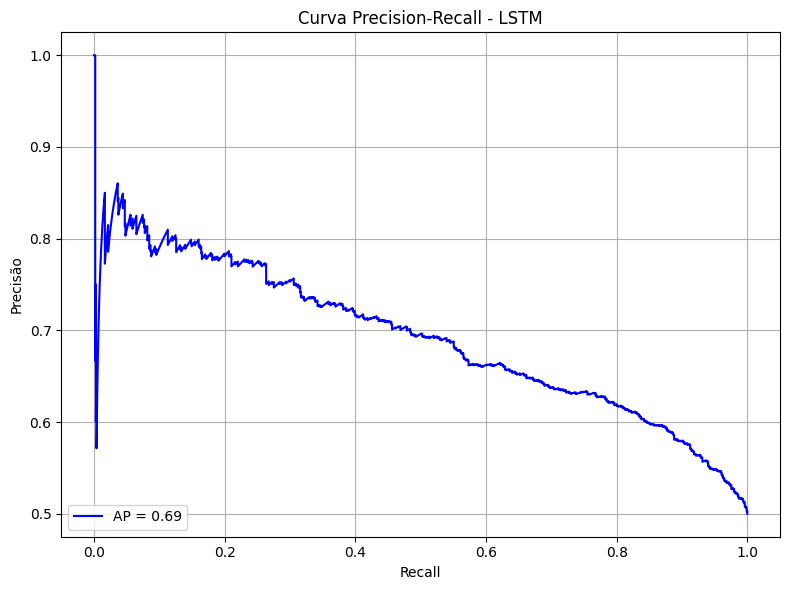

In [ ]:
# Curva Precision-Recall com dados de teste
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
ap_score = average_precision_score(y_test, y_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"AP = {ap_score:.2f}", color="blue")
plt.xlabel("Recall")
plt.ylabel("Precisão")
plt.title("Curva Precision-Recall - LSTM")
plt.legend(loc="lower left")
plt.grid(True)
plt.tight_layout()
plt.show()